input data
변동성
전날 수익
모두 min-max scaling 한다
이유 : 학습에 사용되는 독립 변수들이 여러 개일 때, 이 변수들의 스케일이 다르다면 과적합이나 과소 적합이 발생할 수 있기 때문에

정답 데이터인 moving avg(5일) 변동성은 종속 변수이므로 스케일링 하지 않는다. 

### 구간
train : 2000-01-03 ~ 2011-12-02
validation : 2011-12-05 ~ 2013-11-29


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, LinearConstraint
from IPython.core.interactiveshell import InteractiveShell
import datetime as dt

InteractiveShell.ast_node_interactivity = "all"

In [26]:
# AAPL 데이터 불러오기

AAPL_data = pd.read_csv('data/GSPC.csv')
AAPL_data = AAPL_data.set_index('Date')

#인덱스를 datetime으로 변경
AAPL_data.index = pd.to_datetime(AAPL_data.index)
AAPL_data['log_price_return'] = np.log(AAPL_data['Adj Close']).diff(1)
returns = AAPL_data['log_price_return'].dropna()

In [27]:
def calculate_volatility(returns):
    squared_log_price_return = (returns ** 2).dropna()
    volatility = squared_log_price_return.rolling(window=5).sum() / 5.0

    return volatility.dropna()

## 데이터 셋 만들기 

In [28]:
AAPL_data_set = pd.DataFrame()

tmp = calculate_volatility(returns)
af = AAPL_data['log_price_return']


AAPL_data_set['rv'] = np.sqrt(tmp)
AAPL_data_set['log_return'] = af

In [29]:
# train과 validation 데이터를 분리
split_date= dt.datetime(2011,12,2)
train_AAPL = AAPL_data_set[AAPL_data_set.index<=split_date]
test_AAPL = AAPL_data_set[AAPL_data_set.index>=split_date]

In [30]:
#scaling
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()

train_AAPL_minmax = scaler_minmax.fit_transform(train_AAPL)
test_AAPL_minmax = scaler_minmax.transform(test_AAPL)

#표준화가 완료된 데이터를 데이터 프레임으로 다시 변경
train_AAPL_standard = pd.DataFrame(train_AAPL_minmax, index=train_AAPL.index,columns=train_AAPL.columns)
test_AAPL_standard = pd.DataFrame(test_AAPL_minmax, index=test_AAPL.index,columns=test_AAPL.columns)

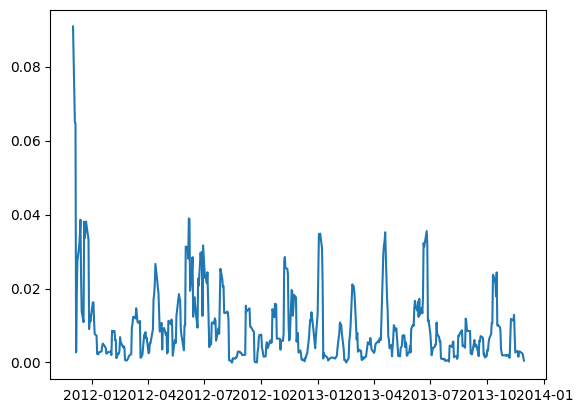

In [31]:
# plt.plot(train_AAPL_standard['rv'])
plt.plot(test_AAPL_standard['rv']**2)

In [32]:
from garch.garch_mle import garch_mle

bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]
#조건 alpha + beta < 1
LC = LinearConstraint([[0,1,1]], lb=0, ub=1)

# DE 알고리즘을 사용한 파라미터 추정
result = differential_evolution(garch_mle, bounds=bounds, args=(train_AAPL['log_return'],), constraints=LC,
                                strategy='best1bin', maxiter=30, popsize=20, tol=1e-5, mutation=(0.3, 1),
                                recombination=0.7)

print("Optimized GARCH(1,1) Parameters:")
print(result.x)

/Users/easydong/DataspellProjects/intern_project/garch/garch_mle.py:7: RuntimeWarning: invalid value encountered in scalar power
  long_run = (omega / (1 - alpha - beta)) ** (1 / 2)
/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Optimized GARCH(1,1) Parameters:
[1.34134838e-06 8.49862322e-02 9.08380581e-01]


In [33]:
omega,alpha,beta = result.x
forecasts = np.zeros(len(test_AAPL))
for t in range(1, len(test_AAPL)):
    forecasts[t] = omega + alpha*test_AAPL['log_return'][t-1]**2 + beta*test_AAPL['rv'][t-1]**2


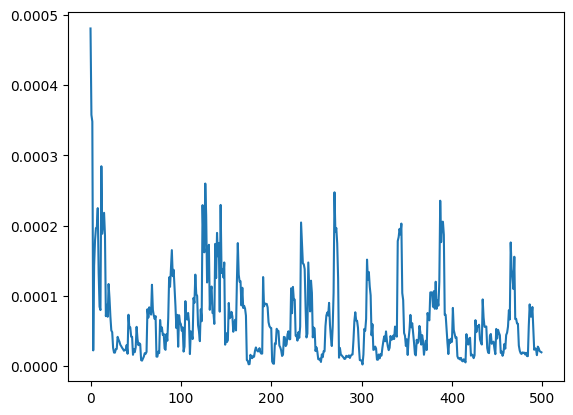

In [34]:
plt.plot(forecasts[1:])

MinMaxScaler()

/Users/easydong/opt/anaconda3/envs/intern_project/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


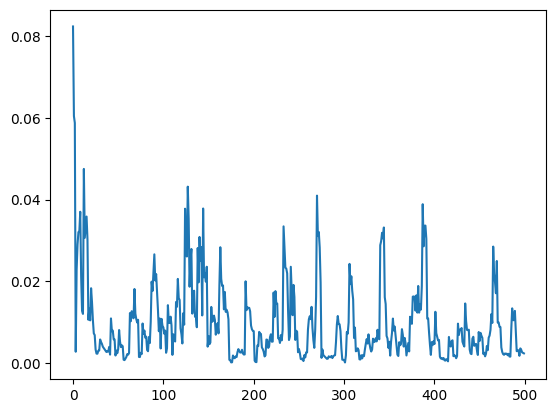

In [35]:
rv_train = pd.DataFrame(train_AAPL['rv'])
scaler_garch = MinMaxScaler()
scaler_garch.fit(rv_train)

forecasts = np.sqrt(forecasts) 
df = scaler_garch.transform(forecasts[1:].reshape(-1,1))
plt.plot(df**2)

<Figure size 1500x1000 with 0 Axes>

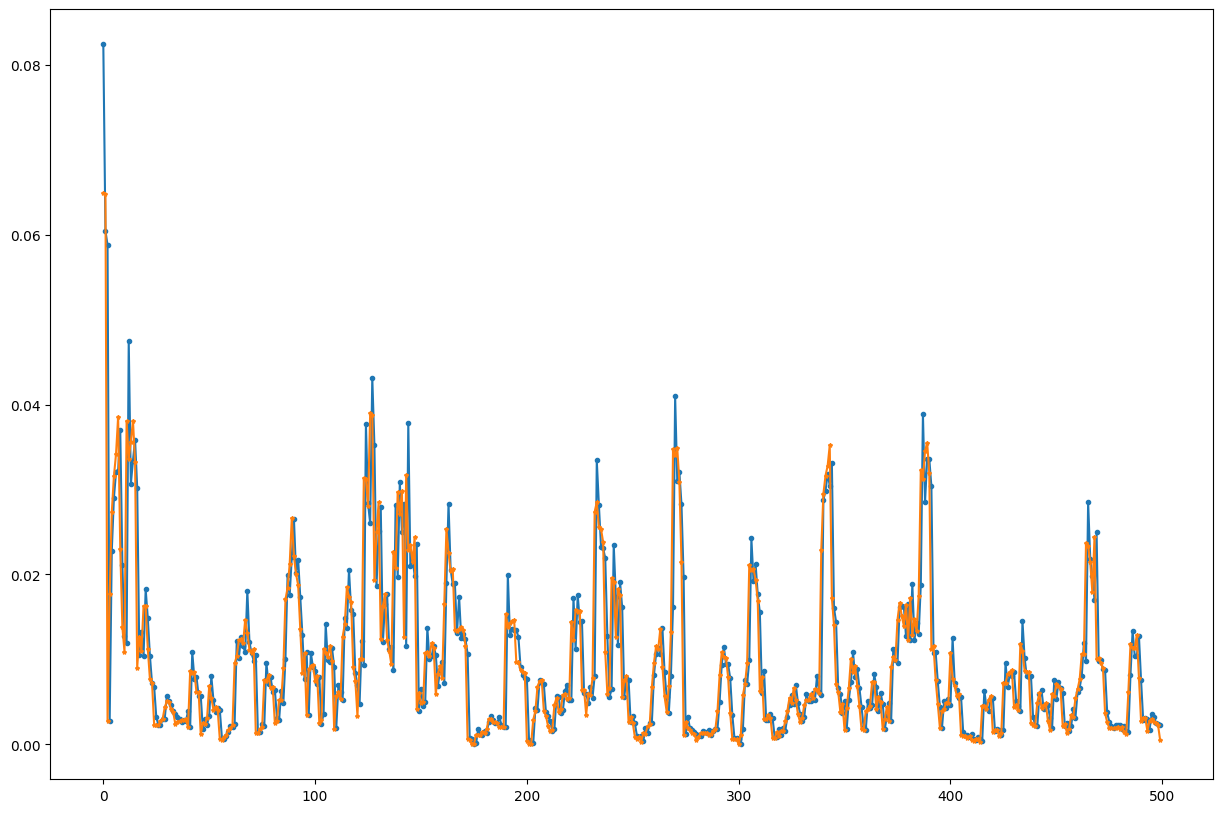

In [39]:
plt.figure(figsize=(15,10))
y = test_AAPL_standard['rv'][1:].values
y_hat = df
plt.plot(y_hat**2,marker='o', markersize=3)
plt.plot(y**2,marker='*', markersize=3)



In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
mean_squared_error(y,y_hat,squared=False)

0.024166834917450558